# PLANT DISEASE DETECTION USING CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Installing Libraries

In [ ]:
! pip install imutils
! pip install opencv-python
! pip install argparse


## Importing Necessary Packages. (from Tensorflow, Scikit-learn, OpemCV )

In [ ]:
# Import the necessary packages from TensorFlow, scikit-learn, OpenCV, and more.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras import backend as K  # to source
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from imutils import paths  # Provides convenience functions for working with image paths.
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2  # OpenCV for image processing
import os

import warnings
from tqdm import tqdm_notebook as tqdm  # tqdm is a progress bar library.
import itertools

import tensorflow as tf  # Import TensorFlow library and print its version.
print(tf.__version__)
warnings.filterwarnings("ignore")  # Ignore warning messages.
SEED = 42  # Set a random seed for reproducibility.


2.15.0


# Creating CNN Model

## 1. LeNet Model

In [ ]:
# create CNN Model
# https://justpaste.it/cyl0b
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, chanel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":    # Channels First (NCHW) Channels Last (NHWC):
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # third set of CONV => RELU => POOL layers
        model.add(Conv2D(100, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


## 2. VGG16 Model

In [ ]:
# vgg16 model
class VGG16:
    @staticmethod
    def build(input_shape, num_classes):
        model = Sequential()

        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # More blocks...

        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

        return model


# Preprocessing

In [ ]:
DATASET = "/content/drive/MyDrive/PlantVillage"  # this folde must contain three subfolder with images
MODEL = "'plant_desease_detection_model.h5'" # name to store the model on disk
PLOT = "plot.png" # plot name

In [ ]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

In [ ]:
DATASET

'/content/drive/MyDrive/PlantVillage'

In [ ]:
MODEL

"'plant_desease_detection_model.h5'"

In [ ]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(DATASET)))
random.seed(42)
random.shuffle(imagePaths)

# progress bar
with tqdm(total=len(imagePaths)) as pbar:

    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        if label == "Pepper__bell___Bacterial_spot":
            label = 0
        elif label == "Pepper__bell___healthy":
            label = 1
        elif label == "Potato___Early_blight":
            label = 2
        elif label == "Potato___healthy":
            label = 3
        elif label == "Potato___Late_blight":
            label = 4
        elif label == "Tomato__Target_Spot":
            label = 5
        elif label == "Tomato__Tomato_mosaic_virus":
            label = 6
        elif label == "Tomato__Tomato_YellowLeaf__Curl_Virus":
            label = 7
        elif label == "Tomato_Bacterial_spot":
            label = 8
        elif label == "Tomato_Early_blight":
            label = 9
        elif label == "Tomato_healthy":
            label = 10
        elif label == "Tomato_Late_blight":
            label = 11
        elif label == "Tomato_Leaf_Mold":
            label = 12
        elif label == "Tomato_Septoria_leaf_spot":
            label = 13
        elif label == "Tomato_Spider_mites_Two_spotted_spider_mite":
            label = 14

        # print("pr: ", label)

        labels.append(label)

        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/4507 [00:00<?, ?it/s]

In [ ]:
data[0].shape

(28, 28, 3)

In [ ]:
labels

[7,
 9,
 1,
 11,
 9,
 14,
 8,
 1,
 14,
 10,
 2,
 1,
 5,
 10,
 1,
 12,
 12,
 14,
 10,
 10,
 5,
 10,
 10,
 13,
 6,
 5,
 10,
 12,
 12,
 6,
 14,
 3,
 0,
 0,
 6,
 4,
 0,
 1,
 11,
 14,
 2,
 14,
 11,
 2,
 0,
 0,
 7,
 1,
 14,
 8,
 5,
 14,
 0,
 2,
 14,
 1,
 7,
 10,
 8,
 12,
 7,
 6,
 10,
 4,
 11,
 3,
 9,
 5,
 10,
 14,
 14,
 2,
 14,
 2,
 13,
 2,
 8,
 10,
 5,
 6,
 4,
 14,
 6,
 2,
 2,
 4,
 6,
 13,
 2,
 13,
 9,
 9,
 2,
 2,
 1,
 8,
 2,
 1,
 11,
 1,
 5,
 8,
 12,
 7,
 4,
 7,
 2,
 2,
 4,
 4,
 3,
 5,
 14,
 7,
 10,
 10,
 6,
 1,
 1,
 5,
 13,
 3,
 2,
 11,
 2,
 10,
 2,
 7,
 13,
 11,
 11,
 1,
 0,
 12,
 4,
 13,
 0,
 11,
 13,
 10,
 11,
 2,
 4,
 14,
 2,
 0,
 6,
 7,
 3,
 13,
 0,
 11,
 9,
 5,
 0,
 12,
 9,
 14,
 1,
 2,
 8,
 2,
 7,
 13,
 7,
 11,
 5,
 5,
 6,
 0,
 0,
 7,
 7,
 9,
 10,
 4,
 13,
 12,
 6,
 14,
 6,
 7,
 1,
 4,
 4,
 10,
 8,
 5,
 9,
 2,
 10,
 14,
 1,
 3,
 0,
 10,
 9,
 10,
 5,
 12,
 9,
 7,
 5,
 11,
 6,
 3,
 7,
 13,
 4,
 8,
 9,
 14,
 7,
 14,
 10,
 2,
 4,
 0,
 10,
 10,
 1,
 8,
 1,
 2,
 11,
 8,
 2,
 8,
 9,
 7,
 

In [ ]:
imagePaths

['/content/drive/MyDrive/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/044ac80b-046b-4571-a43b-7d179f1610bc___UF.GRC_YLCV_Lab 01310.JPG',
 '/content/drive/MyDrive/PlantVillage/Tomato_Early_blight/171b6622-c111-4fe9-b3f9-12b12ee0db06___RS_Erly.B 7836.JPG',
 '/content/drive/MyDrive/PlantVillage/Pepper__bell___healthy/2f9b8f31-1d11-4559-9899-cfe9f92bcc2c___JR_HL 8406.JPG',
 '/content/drive/MyDrive/PlantVillage/Tomato_Late_blight/0d7b0e84-1c99-4699-84ed-ca86aec642e5___GHLB2 Leaf 8652.JPG',
 '/content/drive/MyDrive/PlantVillage/Tomato_Early_blight/3ecc0dc0-87b2-4f7f-894a-8b9d17d7f25d___RS_Erly.B 7413.JPG',
 '/content/drive/MyDrive/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/057ecdbe-a9f1-47ff-8c5e-17ae92ff5670___Com.G_SpM_FL 8427.JPG',
 '/content/drive/MyDrive/PlantVillage/Tomato_Bacterial_spot/1b752a19-0731-4f93-b9ad-ca01fff2ab8b___GCREC_Bact.Sp 6048.JPG',
 '/content/drive/MyDrive/PlantVillage/Pepper__bell___healthy/226a6fd3-6624-4360-8637-3755f4acd3fb___JR_HL 5898.JPG',


In [ ]:
data[0]

array([[[160., 166., 165.],
        [164., 170., 169.],
        [164., 172., 171.],
        ...,
        [129., 131., 131.],
        [123., 125., 126.],
        [123., 125., 126.]],

       [[163., 169., 168.],
        [166., 172., 171.],
        [164., 172., 171.],
        ...,
        [129., 131., 131.],
        [125., 127., 128.],
        [120., 122., 123.]],

       [[162., 168., 167.],
        [162., 168., 167.],
        [161., 167., 165.],
        ...,
        [126., 128., 128.],
        [127., 127., 127.],
        [125., 125., 125.]],

       ...,

       [[148., 153., 151.],
        [149., 154., 152.],
        [141., 148., 145.],
        ...,
        [103., 104., 102.],
        [111., 109., 109.],
        [ 99.,  97.,  96.]],

       [[138., 144., 143.],
        [146., 152., 151.],
        [149., 156., 153.],
        ...,
        [109., 107., 106.],
        [121., 119., 118.],
        [101.,  99.,  98.]],

       [[137., 143., 142.],
        [140., 146., 145.],
        [134., 1

In [ ]:
data[0].shape

(28, 28, 3)

In [ ]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
labels

array([ 7,  9,  1, ..., 11,  0,  2])

# Splitting the data into training & testing

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

label encoding on trainY & testY

In [ ]:
trainY = to_categorical(trainY, num_classes=15)
testY = to_categorical(testY, num_classes=15)

In [ ]:
trainY[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
# constructing the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [ ]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=15)
opt = Adam()

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

[INFO] compiling model...
[INFO] model complied...


In [ ]:
# initialize the model
print("[INFO] compiling model...")

VGGmodel = VGG16.build((28, 28,3), num_classes=15)


[INFO] compiling model...


In [ ]:
adam = Adam(learning_rate=0.001)

VGGmodel.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])
print("[INFO] model complied...")


[INFO] model complied...


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        1520      
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 20)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 50)          0         
 g2D)                                                   

In [ ]:

print(VGGmodel.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        1792      
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                 

In [ ]:
# train the network
print("[INFO] training network...")
lenet = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // BS,
              epochs=20,
              verbose=1)

[INFO] training network...
Epoch 1/20
105/105 [==============================] - 19s 162ms/step - loss: 2.6469 - accuracy: 0.1036 - val_loss: 2.4794 - val_accuracy: 0.1402
Epoch 2/20
105/105 [==============================] - 14s 131ms/step - loss: 2.3449 - accuracy: 0.2165 - val_loss: 1.9496 - val_accuracy: 0.3185
Epoch 3/20
105/105 [==============================] - 14s 130ms/step - loss: 1.8872 - accuracy: 0.3751 - val_loss: 1.6207 - val_accuracy: 0.4650
Epoch 4/20
105/105 [==============================] - 13s 127ms/step - loss: 1.5671 - accuracy: 0.4776 - val_loss: 1.7541 - val_accuracy: 0.4366
Epoch 5/20
105/105 [==============================] - 14s 133ms/step - loss: 1.3732 - accuracy: 0.5352 - val_loss: 1.2781 - val_accuracy: 0.5643
Epoch 6/20
105/105 [==============================] - 13s 123ms/step - loss: 1.2615 - accuracy: 0.5717 - val_loss: 1.1103 - val_accuracy: 0.6096
Epoch 7/20
105/105 [==============================] - 13s 127ms/step - loss: 1.1105 - accuracy: 0.6171 

In [ ]:
# train the network
print("[INFO] training network...")
vgg = VGGmodel.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // BS,
              epochs=20,
              verbose=1)

[INFO] training network...
Epoch 1/20
105/105 [==============================] - 147s 1s/step - loss: 2.7042 - accuracy: 0.0705 - val_loss: 2.7024 - val_accuracy: 0.0665
Epoch 2/20
105/105 [==============================] - 152s 1s/step - loss: 2.7007 - accuracy: 0.0666 - val_loss: 2.7017 - val_accuracy: 0.0621
Epoch 3/20
105/105 [==============================] - 150s 1s/step - loss: 2.6747 - accuracy: 0.0896 - val_loss: 2.9046 - val_accuracy: 0.1233
Epoch 4/20
105/105 [==============================] - 149s 1s/step - loss: 2.4755 - accuracy: 0.1571 - val_loss: 2.3599 - val_accuracy: 0.1970
Epoch 5/20
105/105 [==============================] - 147s 1s/step - loss: 2.2484 - accuracy: 0.2288 - val_loss: 2.0225 - val_accuracy: 0.2884
Epoch 6/20
105/105 [==============================] - 147s 1s/step - loss: 2.0869 - accuracy: 0.2933 - val_loss: 1.7486 - val_accuracy: 0.4064
Epoch 7/20
105/105 [==============================] - 147s 1s/step - loss: 1.9186 - accuracy: 0.3393 - val_loss: 1.

# Visualizing the accuracy & loss

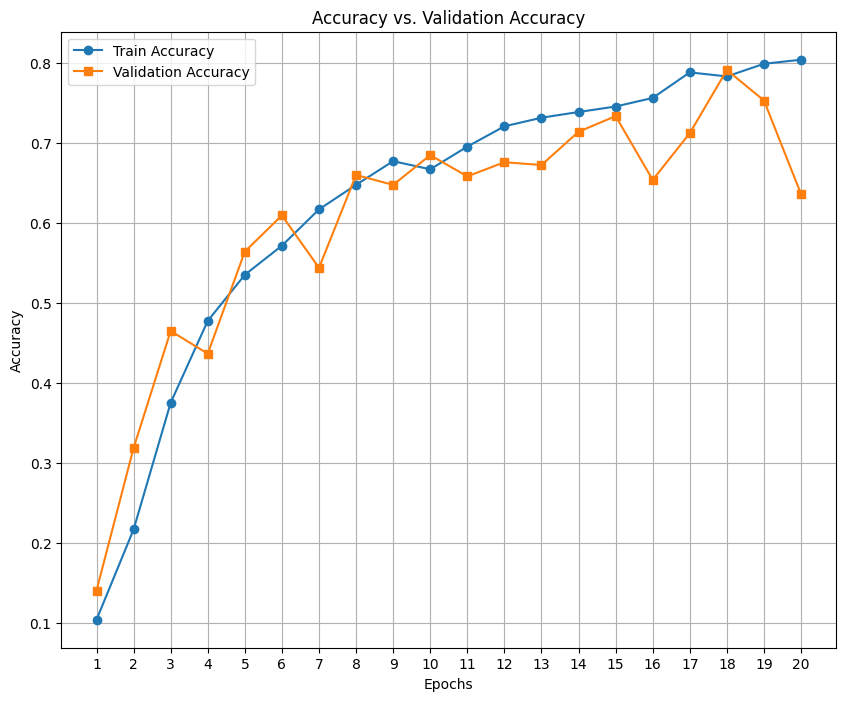

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have stored accuracy and validation accuracy values in lists or arrays
epochs = range(1, len(lenet.history["accuracy"]) + 1)
train_acc = lenet.history["accuracy"]
val_acc = lenet.history["val_accuracy"]

plt.figure(figsize=[10, 8])
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", marker='s')
plt.title("Accuracy vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()


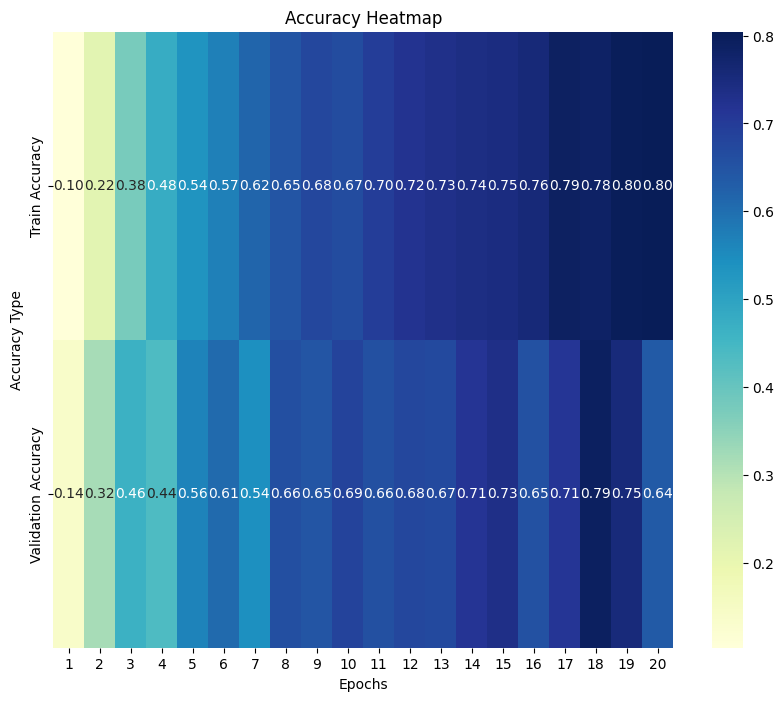

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have stored accuracy and validation accuracy values in lists or arrays
train_acc = lenet.history["accuracy"]
val_acc = lenet.history["val_accuracy"]

# Creating a matrix to store accuracy and validation accuracy
accuracy_matrix = np.column_stack((train_acc, val_acc))

# Plotting heatmap
plt.figure(figsize=[10, 8])
sns.heatmap(accuracy_matrix.T, cmap="YlGnBu", annot=True, fmt=".2f", xticklabels=range(1, len(train_acc) + 1), yticklabels=["Train Accuracy", "Validation Accuracy"])
plt.title("Accuracy Heatmap")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Type")
plt.show()


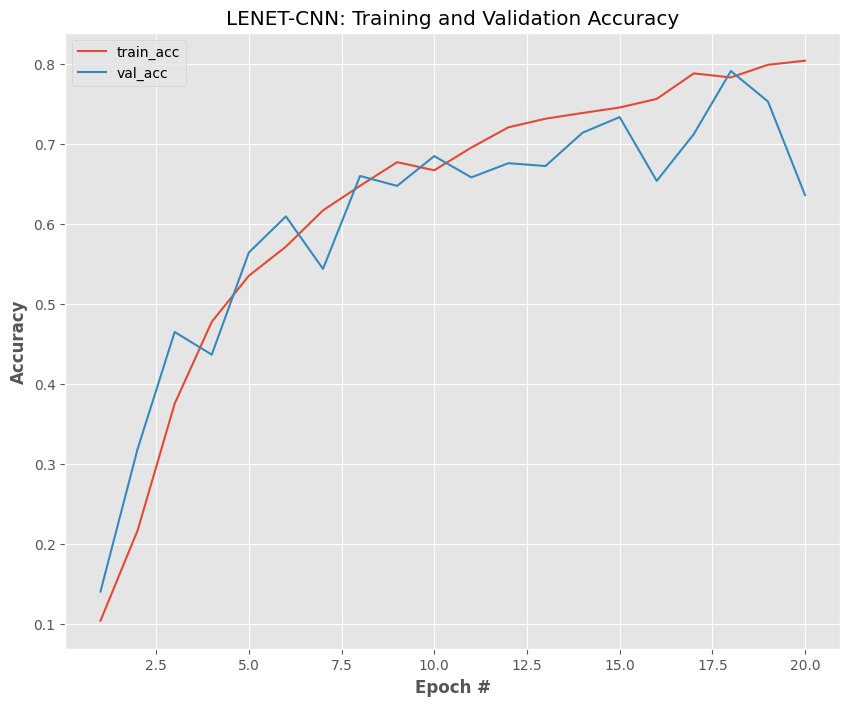

In [ ]:
# plot the training and validation accuracy
N = range(1, len(lenet.history["accuracy"]) + 1)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, lenet.history["accuracy"], label="train_acc")
plt.plot(N, lenet.history["val_accuracy"], label="val_acc")
plt.title("LENET-CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

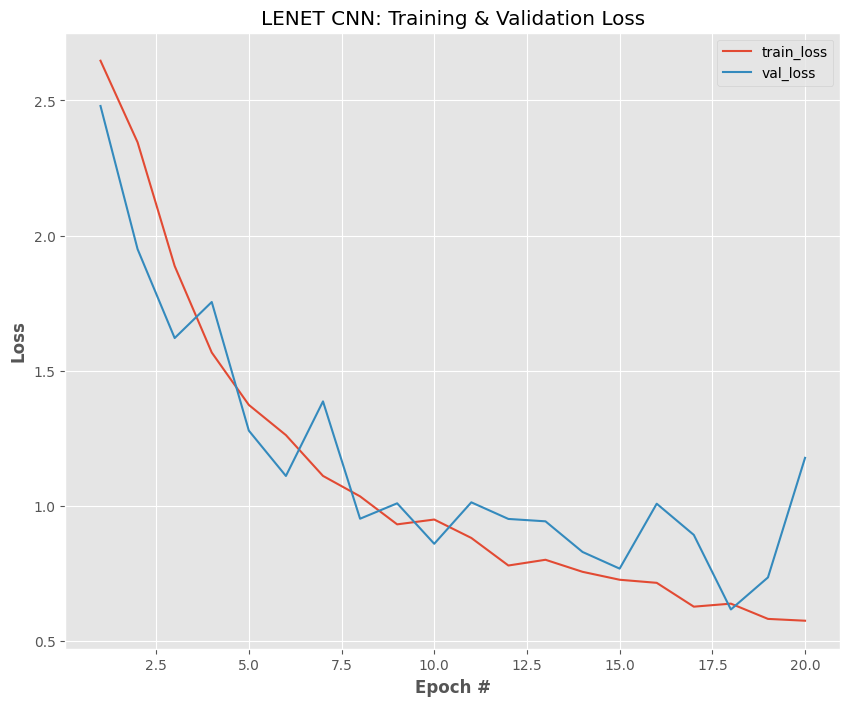

In [ ]:
# plot the training and validation loss
N = range(1, len(lenet.history["accuracy"]) + 1)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, lenet.history["loss"], label="train_loss")
plt.plot(N, lenet.history["val_loss"], label="val_loss")
plt.title("LENET CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

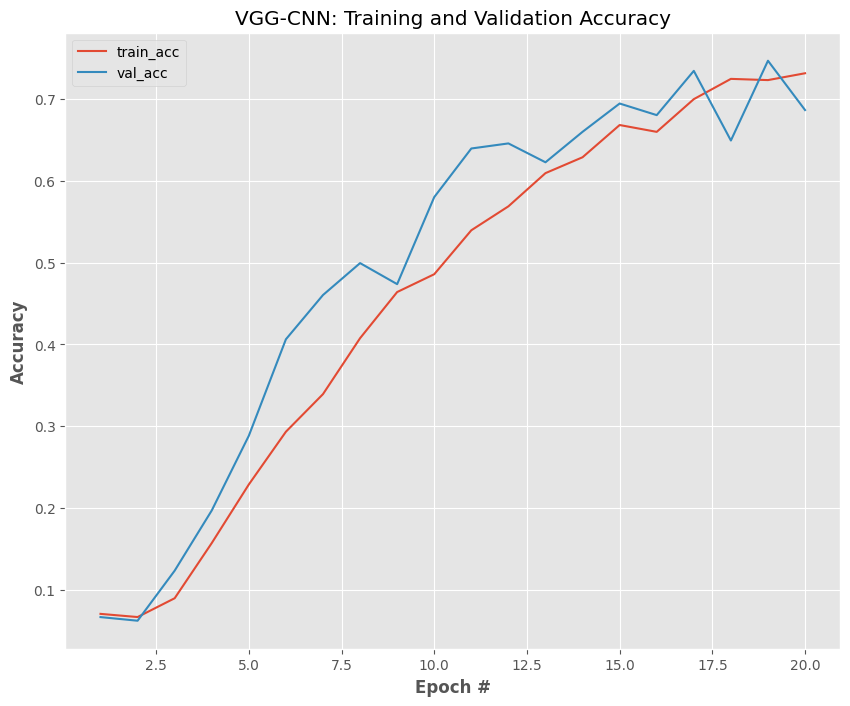

In [ ]:
# plot the training and validation accuracy
N = range(1, len(lenet.history["accuracy"]) + 1)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, vgg.history["accuracy"], label="train_acc")
plt.plot(N, vgg.history["val_accuracy"], label="val_acc")
plt.title("VGG-CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

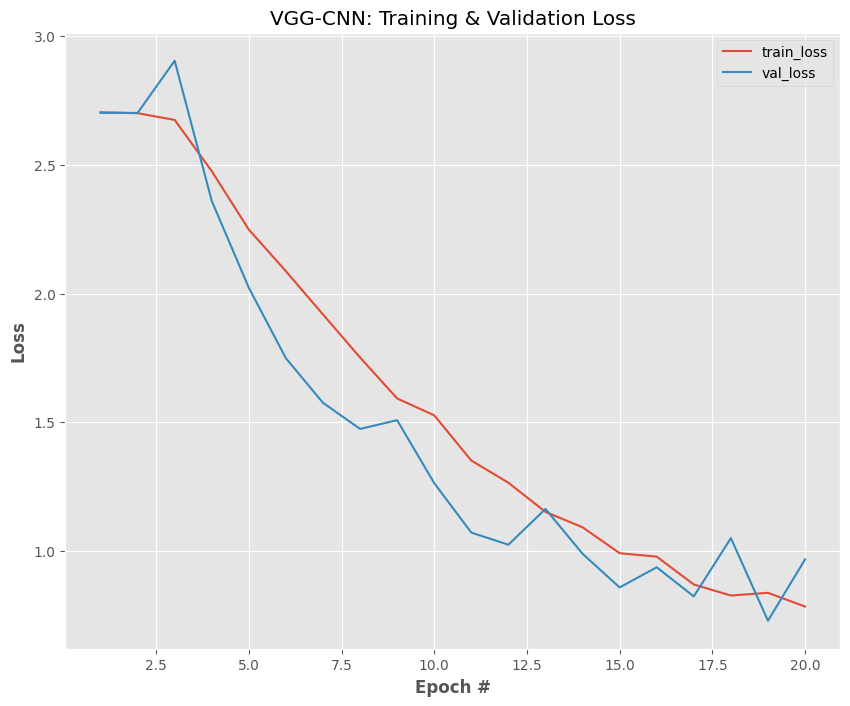

In [ ]:
# plot the training and validation loss
N = range(1, len(lenet.history["accuracy"]) + 1)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, vgg.history["loss"], label="train_loss")
plt.plot(N, vgg.history["val_loss"], label="val_loss")
plt.title("VGG-CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

In [ ]:
trainY.shape

(3380, 15)

In [ ]:
y_pred = VGGmodel.predict(testX
                          )
y_pred.round(2)

36/36 [==============================] - 6s 174ms/step


array([[0.  , 0.  , 0.  , ..., 0.  , 0.07, 0.  ],
       [0.95, 0.  , 0.01, ..., 0.  , 0.03, 0.  ],
       [0.5 , 0.02, 0.  , ..., 0.01, 0.25, 0.  ],
       ...,
       [0.9 , 0.  , 0.02, ..., 0.02, 0.02, 0.  ],
       [0.1 , 0.02, 0.02, ..., 0.  , 0.82, 0.  ],
       [0.74, 0.12, 0.  , ..., 0.  , 0.01, 0.  ]], dtype=float32)

In [ ]:
y_pred.shape

(1127, 15)

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline

In [ ]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)

    ax.imshow(img)

In [ ]:
from tqdm import tqdm

In [ ]:
model.save('plant_desease_detection_model.h5')

In [ ]:
path ='plant_desease_detection_model_v2.h5'

model.save(path)

In [ ]:
import keras

model_deloy=keras.models.load_model('plant_desease_detection_model.h5')

In [ ]:
model_deloy.predict(testX).round(2)

36/36 [==============================] - 1s 26ms/step


array([[0.09, 0.02, 0.  , ..., 0.  , 0.  , 0.1 ],
       [0.56, 0.21, 0.  , ..., 0.  , 0.01, 0.  ],
       [0.24, 0.02, 0.  , ..., 0.02, 0.  , 0.12],
       ...,
       [0.04, 0.  , 0.22, ..., 0.  , 0.01, 0.  ],
       [0.02, 0.92, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.12, 0.72, 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float32)

In [ ]:
model_deloy.predict(np.expand_dims(testX[0], axis=0)).round(2)

1/1 [==============================] - 0s 21ms/step


array([[0.09, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.56, 0.  ,
        0.21, 0.  , 0.  , 0.1 ]], dtype=float32)

In [ ]:
np.argmax(model_deloy.predict(np.expand_dims(testX[0], axis=0)))

1/1 [==============================] - 0s 20ms/step


9

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model
print("[INFO] loading network and...")
model = load_model(path)

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('/content/drive/MyDrive/test_examples')))   # data folder with 2 categorical folders

all_class = ["Pepper__bell___Bacterial_spot","Pepper__bell___healthy","Potato___Early_blight","Potato___healthy",
             "Potato___Late_blight","Tomato__Target_Spot","Tomato__Tomato_mosaic_virus","Tomato__Tomato_YellowLeaf__Curl_Virus",
             "Tomato_Bacterial_spot","Tomato_Early_blight","Tomato_healthy","Tomato_Late_blight","Tomato_Leaf_Mold",
             "Tomato_Septoria_leaf_spot","Tomato_Spider_mites_Two_spotted_spider_mite"]


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf= model.predict(image)[0] # [[0.1 , 0.8 , 0.1]]
        print(prd_conf)

        # build the label
        label = all_class[np.argmax(prd_conf)] #[b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)] # [0.1 , 0.8 , 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)

        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2
import os

# Load the model
print("[INFO] loading network and...")
model = load_model(path)

# Grab the image paths and randomly shuffle them
testImagePaths = sorted(list(paths.list_images('/content/drive/MyDrive/test_examples')))  # Data folder with 2 categorical folders

all_class = ["Pepper__bell___Bacterial_spot","Pepper__bell___healthy","Potato___Early_blight","Potato___healthy",
             "Potato___Late_blight","Tomato__Target_Spot","Tomato__Tomato_mosaic_virus","Tomato__Tomato_YellowLeaf__Curl_Virus",
             "Tomato_Bacterial_spot","Tomato_Early_blight","Tomato_healthy","Tomato_Late_blight","Tomato_Leaf_Mold",
             "Tomato_Septoria_leaf_spot","Tomato_Spider_mites_Two_spotted_spider_mite"]

# Create a directory to save the output images
output_dir = "LENET_output_images"
os.makedirs(output_dir, exist_ok=True)

# Progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        # Load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # Pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # Classify the input image
        prd_conf = VGGmodel.predict(image)[0]  # [[0.1, 0.8, 0.1]]
        print(prd_conf)

        # Build the label
        label = all_class[np.argmax(prd_conf)]  # [b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)]  # [0.1, 0.8, 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # Draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (255, 0, 0), 2)

        # Save the output image with tag
        output_image_path = os.path.join(output_dir, os.path.basename(imagePath))
        cv2.imwrite(output_image_path, output)

        # Convert img to RGB format and display in the notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2
import os

# Load the model
print("[INFO] loading network and...")
model = load_model(path)

# Grab the image paths and randomly shuffle them
testImagePaths = sorted(list(paths.list_images('/content/drive/MyDrive/test_examples')))  # Data folder with 2 categorical folders

all_class = ["Pepper__bell___Bacterial_spot","Pepper__bell___healthy","Potato___Early_blight","Potato___healthy",
             "Potato___Late_blight","Tomato__Target_Spot","Tomato__Tomato_mosaic_virus","Tomato__Tomato_YellowLeaf__Curl_Virus",
             "Tomato_Bacterial_spot","Tomato_Early_blight","Tomato_healthy","Tomato_Late_blight","Tomato_Leaf_Mold",
             "Tomato_Septoria_leaf_spot","Tomato_Spider_mites_Two_spotted_spider_mite"]

# Create a directory to save the output images
output_dir = "VGG_output_images"
os.makedirs(output_dir, exist_ok=True)

# Progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        # Load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # Pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # Classify the input image
        prd_conf = VGGmodel.predict(image)[0]  # [[0.1, 0.8, 0.1]]
        print(prd_conf)

        # Build the label
        label = all_class[np.argmax(prd_conf)]  # [b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)]  # [0.1, 0.8, 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # Draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (255, 0, 0), 2)

        # Save the output image with tag
        output_image_path = os.path.join(output_dir, os.path.basename(imagePath))
        cv2.imwrite(output_image_path, output)

        # Convert img to RGB format and display in the notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


# Creating Interface

In [ ]:
! pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.9 MB/s et

In [ ]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# Load the VGG16 model
VGGmodel = load_model('/content/plant_desease_detection_model_v2.h5')

# Load the LeNet model
model = load_model('/content/plant_desease_detection_model.h5')

# Define the function to use with the LeNet model
def lenet_predict_image(image):
    # Pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    class_labels = ["Pepper__bell___Bacterial_spot","Pepper__bell___healthy","Potato___Early_blight","Potato___healthy",
             "Potato___Late_blight","Tomato__Target_Spot","Tomato__Tomato_mosaic_virus","Tomato__Tomato_YellowLeaf__Curl_Virus",
             "Tomato_Bacterial_spot","Tomato_Early_blight","Tomato_healthy","Tomato_Late_blight","Tomato_Leaf_Mold",
             "Tomato_Septoria_leaf_spot","Tomato_Spider_mites_Two_spotted_spider_mite"]
    result = {
        "class": class_labels[np.argmax(preds)],
        "probabilities": {label: round(float(prob), 3) for label, prob in zip(class_labels, preds)}
    }
    return result

# Define the function to use with the VGG16 model
def vgg16_predict_image(image):
    # Pre-process the image for classification
    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    preds = VGGmodel.predict(image)[0]
    class_labels = [["Pepper__bell___Bacterial_spot","Pepper__bell___healthy","Potato___Early_blight","Potato___healthy",
             "Potato___Late_blight","Tomato__Target_Spot","Tomato__Tomato_mosaic_virus","Tomato__Tomato_YellowLeaf__Curl_Virus",
             "Tomato_Bacterial_spot","Tomato_Early_blight","Tomato_healthy","Tomato_Late_blight","Tomato_Leaf_Mold",
             "Tomato_Septoria_leaf_spot","Tomato_Spider_mites_Two_spotted_spider_mite"]]
    result = {
        "class": class_labels[np.argmax(preds)],
        "probabilities": {label: round(float(prob), 3) for label, prob in zip(class_labels, preds)}
    }
    return result

# Create Gradio interfaces for both models
lenet_interface = gr.Interface(fn=lenet_predict_image, inputs="image", outputs="json", live=True)
vgg16_interface = gr.Interface(fn=vgg16_predict_image, inputs="image", outputs="json", live=True)

# Launch the interfaces separately
lenet_interface.launch(share=True)
vgg16_interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9613d2de120fe6d889.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d7e0e5bdbba3c91e7e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
LENET_output_images

In [ ]:
import os

# Directory containing output images
output_dir = "LENET_output_images"

# List image files in the directory
image_files = os.listdir(output_dir)
print(image_files)


In [ ]:
import os

# Create the output directory if it doesn't exist
output_dir = "LENET_output_images"
os.makedirs(output_dir, exist_ok=True)


In [ ]:
# Save the output image with tag
output_image_path = os.path.join(output_dir, os.path.basename(imagePath))
cv2.imwrite(output_image_path, output)
print("Image saved:", output_image_path)
